# MMMI Oversight Script


Linked problems:
**TODO**: Quarterly share updates after consumption etc.
**TODO**: Debug wealth update: they will need to sell shares sometimes?
-- problem because they are financing consumption with shares which then need to be sold, but the price is moving.

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

**TODO**: Consolidate initial setup to use same scripts as in interim. I.e., by having all agents 'attentive' to start.

**TODO**: Test for expected behavior with maximum attention rating (1)

**TODO**: `requirements.txt`

**TODO**: Begin automated tests

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Fix steady state computation

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa

import logging
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Portfolio Consumption Model

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [2]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [3]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Quarterly dividend rate and standard deviation.

In [4]:
dividend_ror = 0.03
dividend_std = 0.01

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [5]:
# Now set in Financial Model
days_per_quarter = 60 # Number of days in a quarter / An empirical value based on trading calendars.

# Simulation parameters
quarters_per_simulation = 4 # Number of quarters to run total
runs_per_quarter = 5 # Number of market runs to do per quarter

# For John's prefered condition: days per quarter = runs per quarter
# Best if an integer.
days_per_run = days_per_quarter / runs_per_quarter

An attention rate: the chance on any run that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [6]:
attention_rate = 1 / runs_per_quarter ## upping this to make more agents engaged in trade

A times we will need to combine the quarterly rates from the price process (capital gains) and the dividends.


### Data stores

For prices, rates or return, and standard deviations over time.

In [7]:
buy_sell_list = []

owned_shares_list = []
total_asset_levels_list = []

### Calculating risky expectations



In [8]:
import math

class FinanceModel():
    """
    A class representing the financial system in the simulation.

    Contains parameter values for:
      - the capital gains expectations function
      - the dividend
      - the risky asset expectations
      
    Contains data structures for tracking ROR and STD over time.
    """
    # Empirical data
    sp500_ror = 0.000628
    sp500_std = 0.011988
    
    # Simulation parameter
    days_per_quarter = 60
    
    # Expectation calculation parameters    
    p1 = 0.1
    delta_t1 = 30

    a = - math.log(p1) / delta_t1

    p2 = 0.1
    delta_t2 = 60

    b = math.log(p2) / delta_t2
    
    # Quarterly dividend rate and standard deviation.
    dividend_ror = 0.03
    dividend_std = 0.01
    
    # Data structures. These will change over time.
    starting_price = 100
    prices = [starting_price]
    ror_list = []

    expected_ror_list = []
    expected_std_list = []
    
    def add_ror(self, ror):
        self.ror_list.append(ror)
        asset_price = self.prices[-1] * (1 + ror)
        self.prices.append(asset_price)
        return asset_price
    
    def __init__(self, dividend_ror = None, dividend_std = None):
        
        if dividend_ror:
            self.dividend_ror = divedend_ror
            
        if dividend_std:
            self.dividend_std = dividend_std
        pass
    
    def calculate_risky_expectations(self):
        """
        Compute the quarterly expectations for the risky asset based on historical return rates.
    
        In this implementation there are a number of references to:
          - paramters that are out of scope
          - data structures that are out of scope
     
        These should be bundled together somehow.
        
        NOTE: This MUTATES the 'expected_ror_list' and so in current design
        has to be called on a schedule... this should be fixed.
        """
        # note use of data store lists for time tracking here -- not ideal
        D_t = sum([math.exp(self.a * (l + 1)) for l in range(len(self.ror_list))])
        S_t = math.exp(self.b * (len(self.prices) - 1)) # because p_0 is included in this list.
    
        w_0 = S_t
        w_t = [(1 - S_t) * math.exp(self.a * (t+1)) / D_t for t in range(len(self.ror_list))]
    
        print(f"D_t: {D_t}\nS_t / w_0  : {S_t}") # "\nror_list: {ror_list}\n w_t: {w_t}")
    
        expected_ror = w_0 * self.sp500_ror + sum(
            [w_ror[0] * w_ror[1]
             for w_ror
             in zip(w_t, self.ror_list)])
        self.expected_ror_list.append(expected_ror)
    
        expected_std = math.sqrt(
            w_0 * pow(self.sp500_std, 2) \
            +  sum([w_ror_er[0] * pow(w_ror_er[1] - expected_ror, 2)
                    for w_ror_er
                    in zip(w_t, self.ror_list)]))
        self.expected_std_list.append(expected_std)
    
        print(f'daily expectations: {expected_ror},{expected_std}')

    def risky_expectations(self):
        """
        Return quarterly expectations for the risky asset.
        These are the average and standard deviation for the asset
        including both capital gains and dividends.
        """
        # expected capital gains quarterly
        ex_cg_q_ror = hpa.ror_quarterly(self.expected_ror_list[-1], self.days_per_quarter)
        ex_cg_q_std = hpa.sig_quarterly(self.expected_std_list[-1], self.days_per_quarter)
    
        # factor in dividend:
        cg_w_div_ror, cg_w_div_std = hpa.combine_lognormal_rates(
            ex_cg_q_ror,
            ex_cg_q_std,
            self.dividend_ror,
            self.dividend_std
        )
     
        market_risky_params = {
            'RiskyAvg': 1 + cg_w_div_ror,
            'RiskyStd': cg_w_div_std
        }
    
        return market_risky_params
    
    def reset(self):
        """
        Reset the data stores back to original value.
        """
        self.prices = [100]
        self.ror_list = []

        self.expected_ror_list = []
        self.expected_std_list = []

In [9]:
fm = FinanceModel()

fm.calculate_risky_expectations()
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


In [10]:
risky_asset_price = fm.starting_price

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [11]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 5, #3, 
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10
    }] * 20

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

fm.calculate_risky_expectations()
agent_parameters.update(fm.risky_expectations())
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [12]:
def compute_share_demand(agent):
    ## TODO: This is using the RAP from the global scope!
    """
    Computes the number of shares an agent _wants_ to own.
    
    This involves:
      - Computing a solution function based on their
        expectations and personal properties
      - Using the solution and the agent's current normalized
        assets to compute a share number
    """
    agent.assign_parameters(AdjustPrb = 1.0)
    agent.solve()
    asset_normalized = agent.state_now['aNrm']

    # ShareFunc takes normalized market assets as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        asset_normalized
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * asset_normalized \
                        * agent.state_now['pLvl'] \
                        * dollars_per_hark_money_unit 
        
    shares = risky_asset_wealth / risky_asset_price
    
    if (np.isnan(shares)).any():
        print("ERROR: Agent has nan shares")
    
    return shares

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).



### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [13]:
def attend(agent, fm):
    """
    Cause the agent to attend to the financial model.
    
    This will update their expectations of the risky asset.
    They will then adjust their owned risky asset shares to meet their
    target.
    
    Return the delta of risky asset shares ordered through the brokers.
        
    NOTE: This MUTATES the agents with their new target share amounts.
    """
    # Note: this mutates the underlying agent
    agent.assign_parameters(**fm.risky_expectations())
            
    d_shares = compute_share_demand(agent)
            
    delta_shares = d_shares - agent.shares
            
    # NOTE: This mutates the agent
    agent.shares = d_shares
    
    return delta_shares


def compute_total_buy_sell(fm, agents):
    """
    Input: a financial model (fm) and a list of agents (agents)
    
    This method does many things:
      - gets new risky expectations
      - loops through the _attentive_ agents and gives them new risky expectations
      - computes their demand
      - mutates the agent to mark the new share quantity
      - computes the total number of shares to be bought/sold this round

    """
    buy_shares_total = 0
    sell_shares_total = 0
    
    for agent in agents:
        if random.random() < attention_rate:
            delta_shares = attend(agent, fm)
            
            buy_shares_total += delta_shares[delta_shares > 0].sum()
            sell_shares_total += -delta_shares[delta_shares < 0].sum()
            
    buy_sell = (round(buy_shares_total), round(sell_shares_total))
    print("Buy/Sell Limit: " + str(buy_sell))
    return buy_sell

In [14]:
#compute_total_buy_sell(agents)

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [15]:
def update_agent_wealth_capital_gains(agents, old_share_price, ror):
    """
    For all agents,
    given the old share price
    and a rate of return
    
    update the agent's wealth level to adjust
    for the most recent round of capital gains.
    """

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_aNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        # update normalized market assets
        if agent.state_node['aNrm'] < delta_aNrm:
            breakpoint()
        
        agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_aNrm
        
        if (agent.state_now['aNrm'] < 0).any():
            print(f"ERROR: Agent with CRRA {agent.parameters['CRRA']} has negative aNrm after capital gains update.")
            print("Setting normalize assets and shares to 0.")
            agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0
            ## TODO: This change in shares needs to be registered with the Broker.
            agent.shares[(agent.state_now['aNrm'] == 0)] = 0

        # update non-normalized market assets
        agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

In [16]:
def macro_update(agent, fm):
    """
    Input: an agent, a FinancialModel
    
    Simulates one "macro" period for the agent (quarterly by assumption).
    For the purposes of the simulation, award the agent dividend income
    but not capital gains on the risky asset.
    """
    
    #agent.assign_parameters(AdjustPrb = 0.0)
    agent.solve()
        
    ## For risky asset gains in the simulated quarter,
    ## use only the dividend.
    true_risky_expectations = {
        "RiskyAvg" : agent.parameters['RiskyAvg'],
        "RiskyStd" : agent.parameters['RiskyStd']   
    }
        
    dividend_risky_params = {
        "RiskyAvg" : 1 + fm.dividend_ror,
        "RiskyStd" : fm.dividend_std
    }
        
    agent.assign_parameters(**dividend_risky_params)
        
    agent.simulate(sim_periods=1)
        
    ## put back the expectations that include capital gains now
    agent.assign_parameters(**true_risky_expectations)
    
    if (agent.state_now['aNrm'] < 0).any():
        print("ERROR: Agent has NaN aNrm after macro update from share prices. Setting to 0.")
        agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0

Accounting functions.

In [17]:
def total_asset_levels(agents):
    tal = sum(
                [agent.state_now['aLvl'].sum()
                 for agent
                 in agents]
            ) * dollars_per_hark_money_unit
    print("Total Asset Levels: " + str(tal))
    return tal

## Run the main loop



In [18]:
import itertools

seeds = itertools.cycle([0,6,3,2,5,1,4])

# Initialize the financial model
fm = FinanceModel()

# Create the Market wrapper
market = hpa.MarketPNL()

# Initialize the population model
agents = hpa.create_distributed_agents(agent_classes, agent_parameters)
hpa.init_simulations(agents)

for agent in agents:
    agent.shares = compute_share_demand(agent)
            
owned_shares = sum([sum(agent.shares) for agent in agents])
print("Owned: " + str(owned_shares))
owned_shares_list.append(owned_shares)
total_asset_levels_list.append(total_asset_levels(agents))

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")
    
    for agent in agents:
        macro_update(agent, fm)

    day = 0

    for run in range(runs_per_quarter):
        print(f"Q-{quarter}:R-{run}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        # TODO: be explicit about attention rate here!
        buy_sell = compute_total_buy_sell(fm, agents)
        
        market.run_market(
            buy_sell = buy_sell,
            seed = seed
        )
        ror =  market.daily_rate_of_return()
        print("ror: " + str(ror))
        
        new_run = True
        
        for new_day in range(int(days_per_run)):
            if new_run:
                buy_sell_list.append(buy_sell)
                new_run = False
            else:
                buy_sell_list.append((0,0))
            
            day = day + 1
            print(f"Q-{quarter}:D-{day}")
        
            update_agent_wealth_capital_gains(agents, risky_asset_price, ror)
        
            owned_shares = sum([sum(agent.shares) for agent in agents])
            print("Owned Shares: " + str(owned_shares))
            owned_shares_list.append(owned_shares)

            total_asset_levels_list.append(total_asset_levels(agents))

            # combine these steps?
            risky_asset_price = fm.add_ror(ror)
            fm.calculate_risky_expectations()

            print(f"Price end of day {day}: {risky_asset_price}")
        
            print("Tot. Owned Share V: " + str(owned_shares * risky_asset_price))
            print("") # line break for presentation

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini


/home/sb/projects/econ-ark/HARK/HARK/core.py:871: RuntimeWarning: invalid value encountered in add
  self.history[var_name] = np.empty((self.T_sim, self.AgentCount)) + np.nan


Owned: 6359.379704426231
Total Asset Levels: 635937.9704426232
Q-0
Q-0:R-0


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (525, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL525SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 

Elapsed (sys clock), run 0:  61.860576776
ror: 0.03239840367647059
Q-0:D-1
Owned Shares: 6884.25213751055
Total Asset Levels: 949899.2396381894
D_t: 1.0797751623277096
S_t / w_0  : 0.9623506263980885
daily expectations: 0.0018241357974989824,0.013171771852805369
Price end of day 1: 103.23984036764706
Tot. Owned Share V: 710729.0917272222

Q-0:D-2
Owned Shares: 6884.25213751055
Total Asset Levels: 972925.7276565807
D_t: 2.2456895635075416
S_t / w_0  : 0.9261187281287935
daily expectations: 0.0029752378314793024,0.014037635175498718
Price end of day 2: 106.58464639137247
Tot. Owned Share V: 733755.5797456121

Q-0:D-3
Owned Shares: 6884.25213751055
Total Asset Levels: 996698.2371290424
D_t: 3.504614975301709
S_t / w_0  : 0.8912509381337456
daily expectations: 0.0040830015949283776,0.014672233911772392
Price end of day 3: 110.03781879087404
Tot. Owned Share V: 757528.0892180732

Q-0:D-4
Owned Shares: 6884.25213751055
Total Asset Levels: 1021240.9379597936
D_t: 4.863971366180234
S_t / w_0  

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (357, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL357SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 6:  31.156767221999985
ror: 0.005954286029411765
Q-0:D-13
Owned Shares: 7240.867741687329
Total Asset Levels: 1254801.3786312442
D_t: 23.176003010843488
S_t / w_0  : 0.6072021956909885
daily expectations: 0.011891738549171884,0.015320983585664054
Price end of day 13: 147.48441761841633
Tot. Owned Share V: 1067915.1619347332

Q-0:D-14
Owned Shares: 7240.867741687329
Total Asset Levels: 1261160.0509605496
D_t: 26.104647575468725
S_t / w_0  : 0.5843414133735176
daily expectations: 0.011458454549022555,0.015151656241883844
Price end of day 14: 148.3625820257976
Tot. Owned Share V: 1074273.8342640381

Q-0:D-15
Owned Shares: 7240.867741687329
Total Asset Levels: 1267556.5846436701
D_t: 29.266925235637103
S_t / w_0  : 0.5623413251903491
daily expectations: 0.011051401900857809,0.014956101343203378
Price end of day 15: 149.24597527524125
Tot. Owned Share V: 1080670.367947159

Q-0:D-16
Owned Shares: 7240.867741687329
Total Asset Levels: 1273991.2051179362
D_t: 32.681474

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (269, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL269SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 3:  26.250338870000007
ror: 0.0015469330882352942
Q-0:D-25
Owned Shares: 7509.743079679397
Total Asset Levels: 1328695.74934103
D_t: 78.67921793107439
S_t / w_0  : 0.38311868495572876
daily expectations: 0.00792108965156303,0.012446565959276169
Price end of day 25: 157.68055573720503
Tot. Owned Share V: 1184140.462247477

Q-0:D-26
Owned Shares: 7509.743079679397
Total Asset Levels: 1330527.5354031962
D_t: 86.0356404756708
S_t / w_0  : 0.36869450645195756
daily expectations: 0.007503051131173566,0.012273678191780607
Price end of day 26: 157.92447700624626
Tot. Owned Share V: 1185972.248309646

Q-0:D-27
Owned Shares: 7509.743079679397
Total Asset Levels: 1332362.155115836
D_t: 93.97892282291362
S_t / w_0  : 0.35481338923357547
daily expectations: 0.0071104613000497995,0.012083086394856762
Price end of day 27: 158.1687756051695
Tot. Owned Share V: 1187806.868022285

Q-0:D-28
Owned Shares: 7509.743079679397
Total Asset Levels: 1334199.612862412
D_t: 102.55588180882

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (178, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL178SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 2:  27.794113071000027
ror: 0.0015469330882352942
Q-0:D-37
Owned Shares: 7687.399704688032
Total Asset Levels: 1350909.2480919578
D_t: 218.09699039436248
S_t / w_0  : 0.2417315480804104
daily expectations: 0.004307450123866021,0.00975915737460765
Price end of day 37: 160.63264360087865
Tot. Owned Share V: 1234847.3369806525

Q-0:D-38
Owned Shares: 7687.399704688032
Total Asset Levels: 1352819.4742964548
D_t: 236.57548836858538
S_t / w_0  : 0.23263050671536264
daily expectations: 0.004115846412927487,0.009519270770300793
Price end of day 38: 160.88113155231557
Tot. Owned Share V: 1236757.5631851472

Q-0:D-39
Owned Shares: 7687.399704688032
Total Asset Levels: 1354732.6554930727
D_t: 256.52811151827416
S_t / w_0  : 0.22387211385683395
daily expectations: 0.003936748940248721,0.009281743378784872
Price end of day 39: 161.1300038979866
Tot. Owned Share V: 1238670.7443817637

Q-0:D-40
Owned Shares: 7687.399704688032
Total Asset Levels: 1356648.7962529818
D_t: 278.07

Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (88, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL88SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 571

Elapsed (sys clock), run 5:  29.493130138000026
ror: 0.01476899191176471
Q-0:D-49
Owned Shares: 7775.511366050935
Total Asset Levels: 1390847.8317550134
D_t: 568.2986013561856
S_t / w_0  : 0.15252229565390193
daily expectations: 0.0035336872591288974,0.007652131770446864
Price end of day 49: 165.8003161590647
Tot. Owned Share V: 1289182.2427896461

Q-0:D-50
Owned Shares: 7775.511366050935
Total Asset Levels: 1409887.7538715678
D_t: 614.7144896923134
S_t / w_0  : 0.14677992676220697
daily expectations: 0.004243519416247174,0.007883036600454018
Price end of day 50: 168.24901968738592
Tot. Owned Share V: 1308222.1649061968

Q-0:D-51
Owned Shares: 7775.511366050935
Total Asset Levels: 1429208.876443856
D_t: 664.8332130550406
S_t / w_0  : 0.14125375446227545
daily expectations: 0.004908058343418116,0.008030481441966646
Price end of day 51: 170.73388809831124
Tot. Owned Share V: 1327543.2874784875

Q-0:D-52
Owned Shares: 7775.511366050935
Total Asset Levels: 1448815.3525191448
D_t: 718.95016

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (614, 557)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL614SL557.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 1:  32.35522027000002
ror: -0.016082478676470592
Q-1:D-1
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent w

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (534, 285)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL534SL285.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 4:  28.097516262
ror: 0.010361638970588236
Q-1:D-13
Owned Shares: 7384.938376745865
Total Asset Levels: 1370971.8917372928
D_t: 3657.588061075563
S_t / w_0  : 0.06072021956909887
daily expectations: -0.004172909771849669,0.013610088278452573
Price end of day 13: 162.0337956258423
Tot. Owned Share V: 1196609.595647079

Q-1:D-14
Owned Shares: 7384.938376745865
Total Asset Levels: 1383370.7283561316
D_t: 3950.452517538087
S_t / w_0  : 0.058434141337351767
daily expectations: -0.0031483840610395273,0.013653871416858044
Price end of day 14: 163.71273131715137
Tot. Owned Share V: 1209008.4322659157

Q-1:D-15
Owned Shares: 7384.938376745865
Total Asset Levels: 1395898.0372436668
D_t: 4266.680283554925
S_t / w_0  : 0.056234132519034905
daily expectations: -0.002195817827944375,0.013620404949283666
Price end of day 15: 165.4090635339486
Tot. Owned Share V: 1221535.741153452

Q-1:D-16
Owned Shares: 7384.938376745865
Total Asset Levels: 1408555.1495831707
D_t: 4608.135170

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (373, 214)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL373SL214.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  24.843915864999985
ror: -0.0028604198529411764
Q-1:D-25
Owned Shares: 7544.114299913821
Total Asset Levels: 1510732.9155287468
D_t: 9207.909553098652
S_t / w_0  : 0.038311868495572894
daily expectations: 0.0033770923722441686,0.011332848177225104
Price end of day 25: 180.97012935391618
Tot. Owned Share V: 1365259.340716133

Q-1:D-26
Owned Shares: 7544.114299913821
Total Asset Levels: 1506827.7006061478
D_t: 9943.551807558293
S_t / w_0  : 0.03686945064519576
daily expectations: 0.0029289632624839284,0.01104343047950429
Price end of day 26: 180.45247880312291
Tot. Owned Share V: 1361354.1257935353

Q-1:D-27
Owned Shares: 7544.114299913821
Total Asset Levels: 1502933.6562378434
D_t: 10737.880042282575
S_t / w_0  : 0.03548133892335755
daily expectations: 0.002512924156878088,0.010750066464797845
Price end of day 27: 179.93630895024202
Tot. Owned Share V: 1357460.081425232

Q-1:D-28
Owned Shares: 7544.114299913821
Total Asset Levels: 1499050.750471361
D_t: 11595

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (347, 120)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL347SL120.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 6:  24.497658997999963
ror: -0.007267772794117647
Q-1:D-37
Owned Shares: 7771.653377657581
Total Asset Levels: 1458480.0845292953
D_t: 23149.686799427454
S_t / w_0  : 0.02417315480804104
daily expectations: -0.0006304908680240285,0.008087271670914999
Price end of day 37: 174.08226404270007
Tot. Owned Share V: 1352907.015337729

Q-1:D-38
Owned Shares: 7771.653377657581
Total Asset Levels: 1448647.4637302533
D_t: 24997.536596849743
S_t / w_0  : 0.023263050671536268
daily expectations: -0.001108636340396331,0.007979192522411499
Price end of day 38: 172.81707370015215
Tot. Owned Share V: 1343074.3945386866

Q-1:D-39
Owned Shares: 7771.653377657581
Total Asset Levels: 1438886.304185149
D_t: 26992.79891181862
S_t / w_0  : 0.022387211385683402
daily expectations: -0.001552285361709081,0.007851003192076713
Price end of day 39: 171.56107847355517
Tot. Owned Share V: 1333313.2349935824

Q-1:D-40
Owned Shares: 7771.653377657581
Total Asset Levels: 1429196.0865298263
D_t: 

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_


Buy/Sell Limit: (251, 135)


lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model --

Elapsed (sys clock), run 3:  27.445887486999993
ror: -0.0028604198529411764
Q-1:D-49
Owned Shares: 7888.498494111691
Total Asset Levels: 1350541.9625546269
D_t: 58169.84789560976
S_t / w_0  : 0.015252229565390192
daily expectations: -0.004237700735610798,0.006081744328047027
Price end of day 49: 160.20047853875428
Tot. Owned Share V: 1263741.2337089353

Q-1:D-50
Owned Shares: 7888.498494111691
Total Asset Levels: 1346927.132040745
D_t: 62811.436729222536
S_t / w_0  : 0.014677992676220697
daily expectations: -0.004134767456135064,0.005873214383855426
Price end of day 50: 159.74223790949137
Tot. Owned Share V: 1260126.403195054

Q-1:D-51
Owned Shares: 7888.498494111691
Total Asset Levels: 1343322.6414598303
D_t: 67823.30906549525
S_t / w_0  : 0.014125375446227542
daily expectations: -0.004039430805702889,0.0056710518933131854
Price end of day 51: 159.2853080408218
Tot. Owned Share V: 1256521.9126141395

Q-1:D-52
Owned Shares: 7888.498494111691
Total Asset Levels: 1339728.4612353335
D_t: 

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (271, 681)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL271SL681.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 2:  28.016536930999905
ror: -0.02048983161764706
Q-2:D-1
Owned Shares: 7477.775080115607
Total Asset Levels: 892097.1115487253
D_t: 146136.51538238977
S_t / w_0  : 0.00962350626398089
daily expectations: -0.0046895794938499845,0.005948495524654118
Price end of day 1: 152.05064496618309
Tot. Owned Share V: 1137000.5238436295

Q-2:D-2
Owned Shares: 7477.775080115607
Total Asset Levels: 868800.1622659931
D_t: 157795.6593941881
S_t / w_0  : 0.009261187281287936
daily expectations: -0.00584437333218303,0.007046075124167227
Price end of day 2: 148.93515285347135
Tot. Owned Share V: 1113703.574560897

Q-2:D-3
Owned Shares: 7477.775080115607
Total Asset Levels: 845980.5635512683
D_t: 170384.91351212974
S_t / w_0  : 0.008912509381337455
daily expectations: -0.006914687425620101,0.007776269495374088
Price end of day 3: 145.88349664955518
Tot. Owned Share V: 1090883.9758461723

Q-2:D-4
Owned Shares: 7477.775080115607
Total Asset Levels: 823628.5345717912
D_t: 183978.47742

Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (326, 802)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL326SL802.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 5:  30.797784277000005
ror: -0.02489718455882353
Q-2:D-13
Owned Shares: 7001.722519176997
Total Asset Levels: 639427.6440334753
D_t: 367098.7938675474
S_t / w_0  : 0.0060720219569098885
daily expectations: -0.014454052875900309,0.008883176647080928
Price end of day 13: 118.06933410942902
Tot. Owned Share V: 826688.7154582218

Q-2:D-14
Owned Shares: 7001.722519176997
Total Asset Levels: 618845.4225120145
D_t: 396385.2395137998
S_t / w_0  : 0.005843414133735177
daily expectations: -0.015217823633182604,0.00896761219415061
Price end of day 14: 115.12974010736917
Tot. Owned Share V: 806106.4939367617

Q-2:D-15
Owned Shares: 7001.722519176997
Total Asset Levels: 598775.6403584059
D_t: 428008.01611548354
S_t / w_0  : 0.005623413251903492
daily expectations: -0.015925612096372888,0.008987576967548308
Price end of day 15: 112.26333371970662
Tot. Owned Share V: 786036.7117831521

Q-2:D-16
Owned Shares: 7001.722519176997
Total Asset Levels: 579205.5392751294
D_t: 462153.

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (389, 350)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL389SL350.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 1:  28.031890523000015
ror: 0.010361638970588236
Q-2:D-25
Owned Shares: 5262.981556525249
Total Asset Levels: 459275.69245822873
D_t: 922130.9430698561
S_t / w_0  : 0.00383118684955729
daily expectations: -0.018099441976255962,0.0109824819418356
Price end of day 25: 90.4000096691077
Tot. Owned Share V: 475773.58359821804

Q-2:D-26
Owned Shares: 5262.981556525249
Total Asset Levels: 464205.48656321666
D_t: 995695.1685158202
S_t / w_0  : 0.0036869450645195772
daily expectations: -0.01600183529948525,0.012932114473321203
Price end of day 26: 91.33670193223669
Tot. Owned Share V: 480703.3777032058

Q-2:D-27
Owned Shares: 5262.981556525249
Total Asset Levels: 469186.36141491955
D_t: 1075127.9919882482
S_t / w_0  : 0.003548133892335756
daily expectations: -0.014058741150817114,0.014231405802716722
Price end of day 27: 92.28309986242276
Tot. Owned Share V: 485684.25255490874

Q-2:D-28
Owned Shares: 5262.981556525249
Total Asset Levels: 474218.84629359364
D_t: 1160897.

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (249, 288)


pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL249SL288.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695

Elapsed (sys clock), run 4:  27.937198407999972
ror: -0.0028604198529411764
Q-2:D-37
Owned Shares: 5224.027627435262
Total Asset Levels: 514889.0009375665
D_t: 2316308.6677027363
S_t / w_0  : 0.0024173154808041055
daily expectations: -0.0019680719581778735,0.015251722571896834
Price end of day 37: 100.96474862065466
Tot. Owned Share V: 527442.6361913562

Q-2:D-38
Owned Shares: 5224.027627435262
Total Asset Levels: 513380.2935497168
D_t: 2501093.6474449653
S_t / w_0  : 0.0023263050671536276
daily expectations: -0.002033619896911574,0.014680424397448993
Price end of day 38: 100.67594704925293
Tot. Owned Share V: 525933.9288035068

Q-2:D-39
Owned Shares: 5224.027627435262
Total Asset Levels: 511875.9016984319
D_t: 2700619.878941853
S_t / w_0  : 0.0022387211385683408
daily expectations: -0.0020943446449805,0.014130387444014875
Price end of day 39: 100.38797157159959
Tot. Owned Share V: 524429.5369522219

Q-2:D-40
Owned Shares: 5224.027627435262
Total Asset Levels: 510375.8130394652
D_t: 29

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (163, 160)


parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL163SL160.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- T

Elapsed (sys clock), run 0:  26.52946475400006
ror: -0.011675125735294117
Q-2:D-49
Owned Shares: 5227.1077782363645
Total Asset Levels: 492558.08203898114
D_t: 5818324.777320968
S_t / w_0  : 0.001525222956539019
daily expectations: -0.003153142685016419,0.009935988130523947
Price end of day 49: 96.69076649331909
Tot. Owned Share V: 505413.05762086425

Q-2:D-50
Owned Shares: 5227.1077782363645
Total Asset Levels: 486657.3210429982
D_t: 6282483.660682245
S_t / w_0  : 0.0014677992676220707
daily expectations: -0.0037816261915455235,0.009818265882660167
Price end of day 50: 95.56188963706762
Tot. Owned Share V: 499512.2966248812

Q-2:D-51
Owned Shares: 5227.1077782363645
Total Asset Levels: 480825.45217357704
D_t: 6783670.894309517
S_t / w_0  : 0.001412537544622755
daily expectations: -0.004363751194921078,0.009671562599956817
Price end of day 51: 94.44619256005255
Tot. Owned Share V: 493680.42775546014

Q-2:D-52
Owned Shares: 5227.1077782363645
Total Asset Levels: 475061.67110647843
D_t: 

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (310, 168)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL310SL168.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks

Elapsed (sys clock), run 6:  27.612728359000016
ror: 0.0015469330882352942
Q-3:D-1
Owned Shares: 5369.3989702902745
Total Asset Levels: 495701.4960667776
D_t: 14614991.525998965
S_t / w_0  : 0.0009623506263980887
daily expectations: -0.007300266798625594,0.007878481150670866
Price end of day 1: 85.1046505932948
Tot. Owned Share V: 456960.82326255075

Q-3:D-2
Owned Shares: 5369.3989702902745
Total Asset Levels: 496408.38388431014
D_t: 15780905.927178796
S_t / w_0  : 0.0009261187281287935
daily expectations: -0.006646953023466277,0.007927902705823666
Price end of day 2: 85.23630179326028
Tot. Owned Share V: 457667.7110800828

Q-3:D-3
Owned Shares: 5369.3989702902745
Total Asset Levels: 497116.3652099967
D_t: 17039831.338972963
S_t / w_0  : 0.0008912509381337461
daily expectations: -0.006041873462356061,0.00792541994459036
Price end of day 3: 85.36815664882309
Tot. Owned Share V: 458375.69240576954

Q-3:D-4
Owned Shares: 5369.3989702902745
Total Asset Levels: 497825.44173542195
D_t: 18399

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (219, 49)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL219SL49.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 3:  23.720263405999958
ror: 0.01476899191176471
Q-3:D-13
Owned Shares: 5540.159684152209
Total Asset Levels: 510620.5797245893
D_t: 36711219.37451473
S_t / w_0  : 0.0006072021956909886
daily expectations: -0.0010003868105089451,0.007897205805234573
Price end of day 13: 87.84253099908409
Tot. Owned Share V: 486661.6487950163

Q-3:D-14
Owned Shares: 5540.159684152209
Total Asset Levels: 517808.0816794086
D_t: 39639863.93913996
S_t / w_0  : 0.0005843414133735176
daily expectations: 0.0001640303535933743,0.008646953044776412
Price end of day 14: 89.1398766289185
Tot. Owned Share V: 493849.15074983594

Q-3:D-15
Owned Shares: 5540.159684152209
Total Asset Levels: 525101.7357924655
D_t: 42802141.59930834
S_t / w_0  : 0.0005623413251903491
daily expectations: 0.001242466862797362,0.009156283992610032
Price end of day 15: 90.45638274586669
Tot. Owned Share V: 501142.8048628921

Q-3:D-16
Owned Shares: 5540.159684152209
Total Asset Levels: 532503.1098241243
D_t: 46216690.

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (107, 42)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL107SL42.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 2:  25.55680604500003
ror: 0.005954286029411765
Q-3:D-25
Owned Shares: 5604.457674126767
Total Asset Levels: 599232.3010054841
D_t: 92214434.29474558
S_t / w_0  : 0.0003831186849557289
daily expectations: 0.007836692068404903,0.009031361395809546
Price end of day 25: 103.8298329019798
Tot. Owned Share V: 581909.9038108006

Q-3:D-26
Owned Shares: 5604.457674126767
Total Asset Levels: 602697.1590161204
D_t: 99570856.83934198
S_t / w_0  : 0.0003686945064519576
daily expectations: 0.00769756874537138,0.008705485933609395
Price end of day 26: 104.44806542546421
Tot. Owned Share V: 585374.7618214375

Q-3:D-27
Owned Shares: 5604.457674126767
Total Asset Levels: 606182.6477824033
D_t: 107514139.1865848
S_t / w_0  : 0.0003548133892335755
daily expectations: 0.007568724078051124,0.008390335986208525
Price end of day 27: 105.06997908222613
Tot. Owned Share V: 588860.2505877211

Q-3:D-28
Owned Shares: 5604.457674126767
Total Asset Levels: 609688.8901457544
D_t: 116091098.1

Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (129, 119)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL129SL119.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 5:  30.294495417999997
ror: -0.011675125735294117
Q-3:D-37
Owned Shares: 5614.429186282932
Total Asset Levels: 631235.701850901
D_t: 231632206.75803357
S_t / w_0  : 0.0002417315480804103
daily expectations: 0.005401147673796988,0.007520341781049923
Price end of day 37: 109.5424827505712
Tot. Owned Share V: 615018.5122927016

Q-3:D-38
Owned Shares: 5614.429186282932
Total Asset Levels: 624055.2833903498
D_t: 250110704.73225647
S_t / w_0  : 0.0002326305067153627
daily expectations: 0.004139782502429345,0.00850464414330742
Price end of day 38: 108.26356049110198
Tot. Owned Share V: 607838.0938321507

Q-3:D-39
Owned Shares: 5614.429186282932
Total Asset Levels: 616958.6972181587
D_t: 270063327.88194525
S_t / w_0  : 0.0002238721138568342
daily expectations: 0.0029715888937049775,0.009170511156906336
Price end of day 39: 106.99956980981774
Tot. Owned Share V: 600741.5076599588

Q-3:D-40
Owned Shares: 5614.429186282932
Total Asset Levels: 609944.9645818183
D_t: 291607

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (77, 73)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL77SL73.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 1:  27.23909361699998
ror: -0.007267772794117647
Q-3:D-49
Owned Shares: 5617.95719026044
Total Asset Levels: 552773.4861248436
D_t: 581833817.7198566
S_t / w_0  : 0.00015252229565390185
daily expectations: -0.004550068888804161,0.00944978353900855
Price end of day 49: 95.5678212570431
Tot. Owned Share V: 536895.9285885298

Q-3:D-50
Owned Shares: 5617.95719026044
Total Asset Levels: 548871.4485017757
D_t: 628249706.0559844
S_t / w_0  : 0.00014677992676220703
daily expectations: -0.004750798231958918,0.009121797803376613
Price end of day 50: 94.87325604571807
Tot. Owned Share V: 532993.8909654616

Q-3:D-51
Owned Shares: 5617.95719026044
Total Asset Levels: 544997.770001586
D_t: 678368429.4187114
S_t / w_0  : 0.0001412537544622756
daily expectations: -0.004936700649394679,0.008803071525224002
Price end of day 51: 94.18373877653964
Tot. Owned Share V: 529120.2124652719

Q-3:D-52
Owned Shares: 5617.95719026044
Total Asset Levels: 541152.2445166128
D_t: 732485382.073

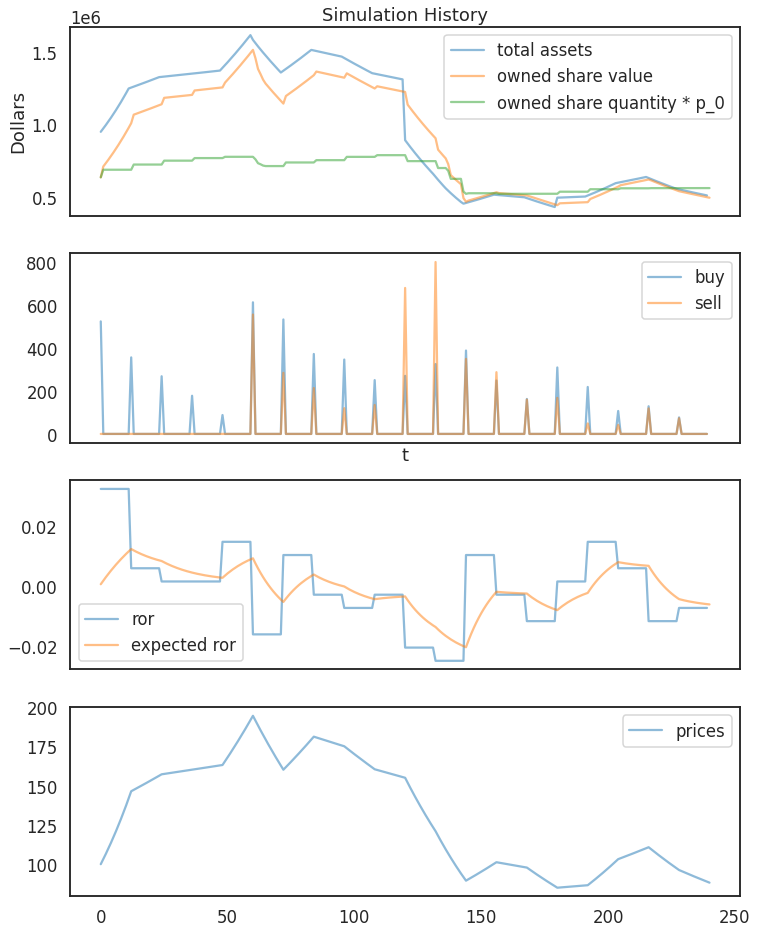

In [19]:
fig, ax = plt.subplots(
    4, 1,
    sharex='col',
    #sharey='col',
    figsize=(12,16),
)

ax[0].plot(total_asset_levels_list[1:], alpha=0.5, label='total assets')
ax[0].plot([p * o for (p,o) in zip(fm.prices, owned_shares_list)], alpha=0.5, label='owned share value')
ax[0].plot([100 * o for (p,o) in zip(fm.prices, owned_shares_list)], alpha=0.5, label='owned share quantity * p_0')
ax[0].legend()

ax[1].plot([bs[0] for bs in buy_sell_list], alpha=0.5, label='buy')
ax[1].plot([bs[1] for bs in buy_sell_list], alpha=0.5, label='sell')
ax[1].legend()

ax[2].plot(fm.ror_list, alpha=0.5, label='ror')
ax[2].plot(fm.expected_ror_list, alpha=0.5, label='expected ror')
ax[2].legend()

ax[3].plot(fm.prices, alpha=0.5, label='prices')
ax[3].legend()
    
ax[0].set_title("Simulation History")
ax[0].set_ylabel("Dollars")
ax[1].set_xlabel("t")
        
plt.show()

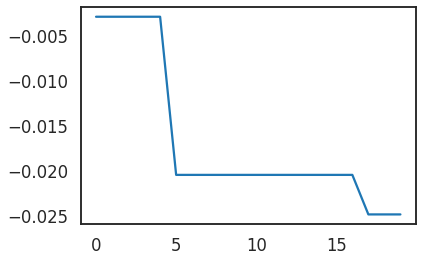

In [20]:
plt.plot(fm.ror_list[115:135])

In [21]:
data = pd.DataFrame.from_dict({
    't' : range(len(fm.prices)),
    'prices' : fm.prices,
    'buy' : [None] + [bs[0] for bs in buy_sell_list],
    'sell' : [None]  + [bs[1] for bs in buy_sell_list],
    'owned' : owned_shares_list,
    'total_assets' : total_asset_levels_list,
    'ror' : [None] + fm.ror_list,
    'expected_ror' : fm.expected_ror_list,
    #'expected_ror_q' : [ror_quarterly(er, days_per_quarter) for er in expected_ror_list],
    'expected_std' : fm.expected_std_list,
    #'expected_std_q' : [sig_quarterly(es, days_per_quarter) for es in expected_std_list],
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,6359.379704,6.359380e+05,NaN,0.000628,0.011988
1,1,103.239840,525.0,0.0,6884.252138,9.498992e+05,0.032398,0.001824,0.013172
2,2,106.584646,0.0,0.0,6884.252138,9.729257e+05,0.032398,0.002975,0.014038
3,3,110.037819,0.0,0.0,6884.252138,9.966982e+05,0.032398,0.004083,0.014672
4,4,113.602868,0.0,0.0,6884.252138,1.021241e+06,0.032398,0.005149,0.015130
...,...,...,...,...,...,...,...,...,...
236,236,90.810597,0.0,0.0,5617.957190,5.260476e+05,-0.007268,-0.005679,0.007347
237,237,90.150606,0.0,0.0,5617.957190,5.223398e+05,-0.007268,-0.005797,0.007083
238,238,89.495412,0.0,0.0,5617.957190,5.186590e+05,-0.007268,-0.005905,0.006827
239,239,88.844980,0.0,0.0,5617.957190,5.150048e+05,-0.007268,-0.006006,0.006580


In [22]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,-0.739273,-0.092499,0.010603,-0.768768,-0.794486,-0.334399,-0.418827,-0.405420
prices,-0.739273,1.000000,0.049969,0.026117,0.916261,0.976004,0.066048,0.414538,0.020178
buy,-0.092499,0.049969,1.000000,0.704956,0.059739,0.054922,0.017598,-0.003027,0.050490
sell,0.010603,0.026117,0.704956,1.000000,0.028110,-0.021355,-0.145526,-0.114569,-0.036298
owned,-0.768768,0.916261,0.059739,0.028110,1.000000,0.907217,0.020554,0.264469,-0.096119
total_assets,-0.794486,0.976004,0.054922,-0.021355,0.907217,1.000000,0.194238,0.486729,0.065359
ror,-0.334399,0.066048,0.017598,-0.145526,0.020554,0.194238,1.000000,0.635533,0.385369
expected_ror,-0.418827,0.414538,-0.003027,-0.114569,0.264469,0.486729,0.635533,1.000000,0.237126
expected_std,-0.405420,0.020178,0.050490,-0.036298,-0.096119,0.065359,0.385369,0.237126,1.000000


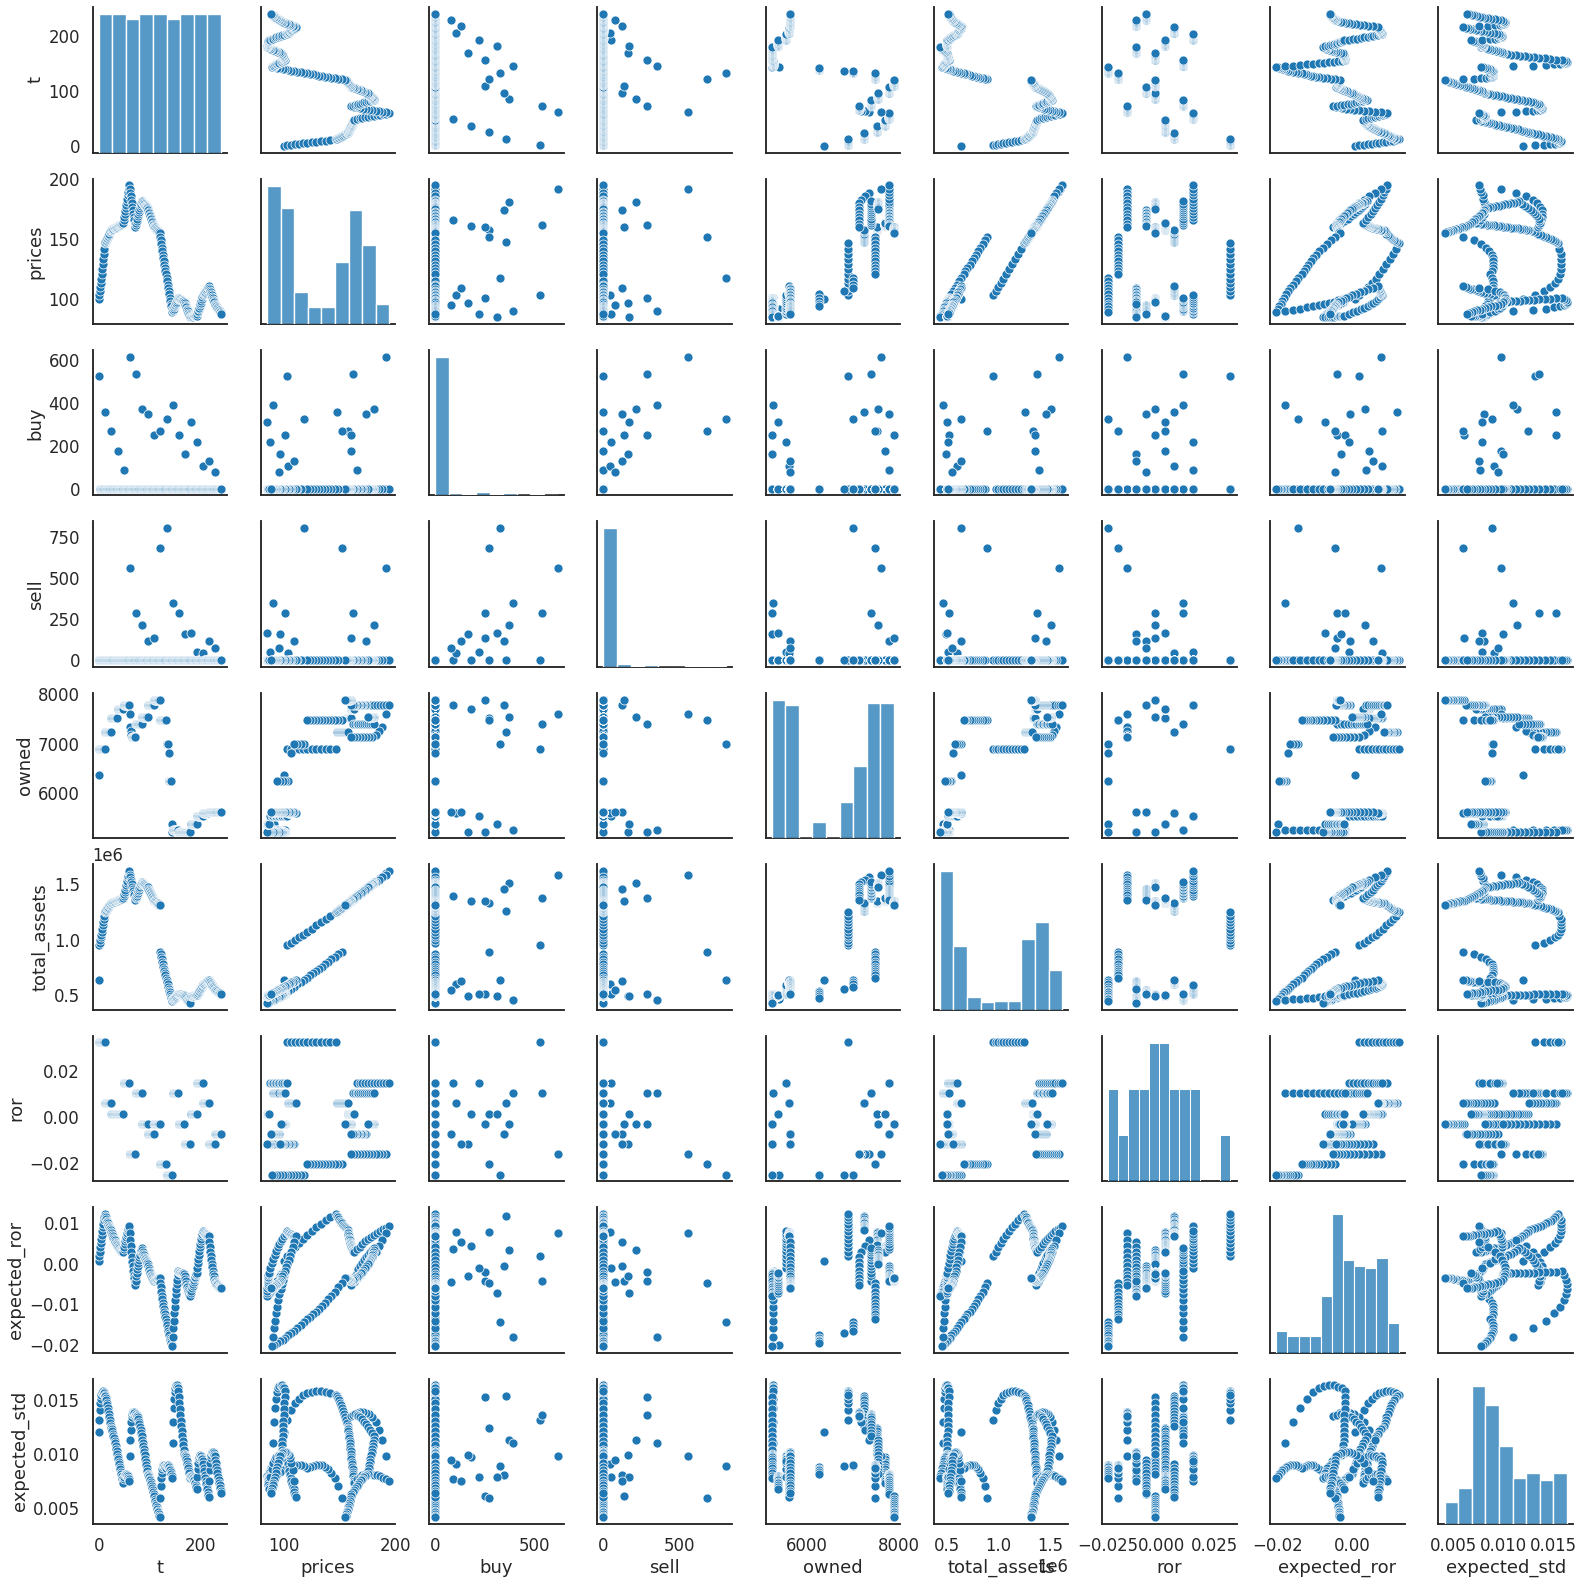

In [23]:
import seaborn as sns

sns.pairplot(data)